COPYRIGHT © 2018 Kiran Arun <kironni@gmail.com>

### Setup

In [2]:
# get dependencies
!rm -r Reinforcement_Learning-101-demo/
!git clone -b improvements https://github.com/KiranArun/Reinforcement_Learning-101-demo.git
from google.colab import auth
auth.authenticate_user()
!chmod +x Reinforcement_Learning-101-demo/scripts/setup.sh
!./Reinforcement_Learning-101-demo/scripts/setup.sh

Getting files from drive
Getting ./A3C_workshop-part_1.ipynb
Getting ./A3C_workshop-part_2.ipynb
Getting ./A3C_Definitions.ipynb
Getting ./COPYRIGHT
Getting ./A3C_helper_functions.py
Getting ./README.md
Getting ./LICENSE
Getting ./imgs/Training_process.png
Getting ./imgs/Inference_overview.png
Getting ./scripts/setup.sh
Getting ./scripts/install_dependencies.sh
Getting ./scripts/get_drive_files.py
Getting ./scripts/install_ngrok.sh
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/events.out.tfevents.1524684056.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/checkpoint
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/final_model.ckpt.data-00000-of-00001
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/final_model.ckpt.meta
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/model.ckpt-5500.data-00000-of-00001
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/model.ckpt-5500.meta
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/final_model.ckpt.index
Getting ./logdir/run_01-lr_0.0001-

Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_16/events.out.tfevents.1524684050.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_15/events.out.tfevents.1524684064.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_14/events.out.tfevents.1524684055.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_13/events.out.tfevents.1524684056.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_12/events.out.tfevents.1524684051.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_11/events.out.tfevents.1524684057.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_10/events.out.tfevents.1524684052.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_9/events.out.tfevents.1524684065.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_8/events.out.tfevents.1524684054.f9349e5b9d46
Getting ./logdir/run_01-lr_0.0001-nw_24-tmax_50/worker_7/events.out.tfevents.1524684

In [4]:
# run tensorboard
get_ipython().system_raw('tensorboard --logdir=/content/logdir/ --host=0.0.0.0 --port=6006 &')
get_ipython().system_raw('/content/ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print('Tensorboard Link:', json.load(sys.stdin)['tunnels'][0]['public_url'])"

Tensorboard Link: https://fce07b5f.ngrok.io


# Reinforcement Learning (RL)

We are going to create a model to play space invaders.

#### Notebook information:
- this notebook will load a checkpoint from the given file and run and display an example game
- it will also take the average steps and rewards of multiple games for performance evaluation
- we will go through what A3C is, and how training works in the second notebook

### Importing Libraries

In [0]:
import numpy as np                     # our linear algebra library
import matplotlib.pyplot as plt        # our plotting library
import tensorflow as tf                # our machine learning library

import gym                             # the environment library
import cv2                             # our image processing library

import time,os,sys
from IPython.display import HTML,Image # to show videos and images

import A3C_helper_functions as helper  # helper functions

### How it will work:

It will interact with its environment (the game) by:
1. revieving the frame from the game as an image (we will call this the state)
2. scoring each possible action using a neural network (the higher the score, the better the action)
3. selecting the action with the greatest score and feeding that into the environment
4. the environment will then act out the action, and return a reward (the greater the reward, the better the model is doing)

### Environment information:
- we're using the [Space Invaders](https://gym.openai.com/envs/SpaceInvaders-v0/) environment from the [OpenAI gym](https://gym.openai.com/)
- the output state (image) is $210\times160\times3$ (we will input is as a $84\times84\times1$ binary array)
- there are 6 possible actions [do nothing, shoot, move right, move left, move right and shoot, move left and shoot]
- each action will be acted out for $U\{2,3,4\}$ frames
- because some frames, the bullets don't show, we take the maximum pixel value from the current and previous frame

See below for example frames.

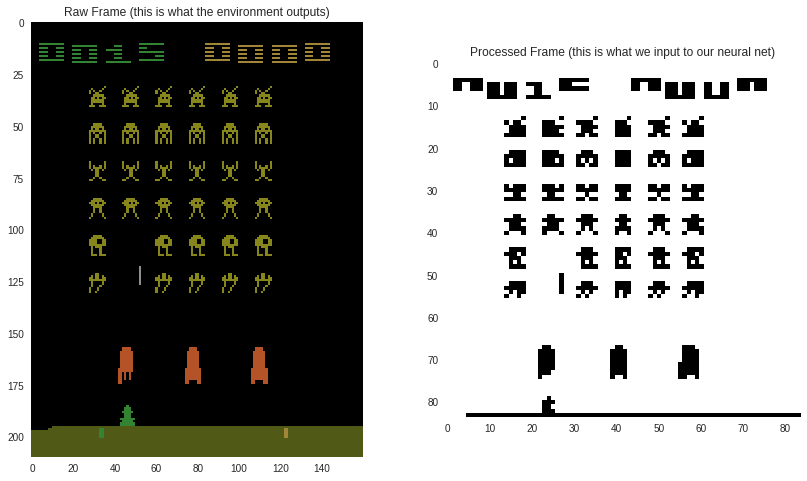

In [6]:
fig,ax = plt.subplots(1,2, figsize=(14,8))
helper.Display_example_frames(fig,ax)

### Settings

**state_size:** the input frame size (the image will be unstacked into a vector)

**num_actions:** number of possible actions in environment

**run:** choose from whatever run you want

**checkpoint:** choose from whatever checkpoint you want

In [7]:
state_size = 84**2  # the size of our input image (unstacked)
num_actions = 6     # the number of possible actions to take in environment

# setup directories
model_root_dir = '/content/'
model_logdir = os.path.join(model_root_dir,'logdir/')


print('Choose from these runs:')
for i in os.listdir(model_logdir):
    print(i)

Choose from these runs:
run_01-lr_0.0001-nw_24-tmax_50


In [0]:
# choose from one of the options above
run = 'run_01-lr_0.0001-nw_24-tmax_50'

In [9]:
print("Choose from these checkpoints:")
for i in [f for f in os.listdir(model_logdir+run) if f.endswith('.meta')]:
    print(i[:-5])

Choose from these checkpoints:
model.ckpt-1500
model.ckpt-3000
model.ckpt-2000
model.ckpt-4000
model.ckpt-1000
model.ckpt-500
model.ckpt-5500
model.ckpt-3500
model.ckpt-2500
final_model.ckpt
model.ckpt-5000
model.ckpt-4500


In [0]:
# choose from one of the options above
checkpoint = 'final_model.ckpt'

# this is the model we are choosing
model_checkpoint = os.path.join(model_logdir,run+'/'+checkpoint)

### The Neural Network

**Inputs:** the input frame(s) (state)
- input the frames unstacked into 1 vector per image
- then put the images back into their image shape
- None is the batch size but we only feed 1 frame per forward pass in inference

---

**Conv net:** 2 convolutional layers
- to analyse the image
- activation: ELU (Exponential Linear Unit)

## $e(x,\alpha) =
    \begin{cases}
            x & \text{if } x \ge 0,\\
            \alpha(e^x-1) & \text{if } x < 0.
    \end{cases}$


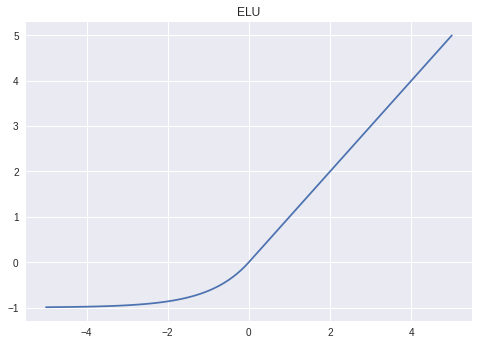

In [11]:
def elu(x,alpha):
    
    out = np.copy(x)
    out[x<0] = alpha*(np.exp(x[x<0]) - 1)
    
    return(out)

x = np.linspace(-5,5,101)
y = elu(x,alpha=1.0)

plt.title('ELU')
plt.plot(x,y)
plt.show()

---

**Fully Connected:** a single fully connected layer
- to finish analysing the image
- activation: ELU (Exponential Linear Unit)

---

**LSTM:** a Long Short Term Memory cell
- we input the output of fc1 and the lstm state
- the lstm cell will output an updated lstm state every forward pass, and we'll pass that in next step
- this will allow the neural net to make a decision based on not just the current input, but the history (the lstm state)
- this goes for all recurrent neural networks (lstm's are a subcatagory)

RNN/LSTM cell


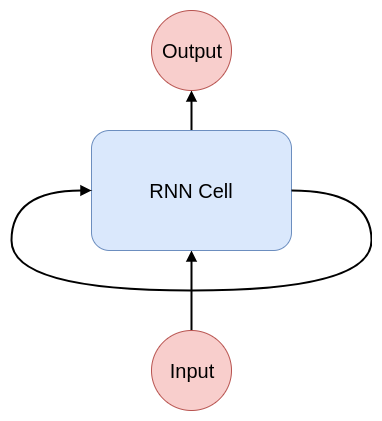

In [12]:
print('RNN/LSTM cell')
Image('Reinforcement_Learning-101-demo/imgs/RNN.png')

---

**Policy:** the fully connected output layer
- we use a final fully connected layer to out 6 probabilities
- the probability represents how good its corresponding action is
- eg. $\left[ \begin{array}{ccc} 0.2 & 0.05 & 0.02 & 0.1 & 0.03 & 0.6 \end{array} \right]$

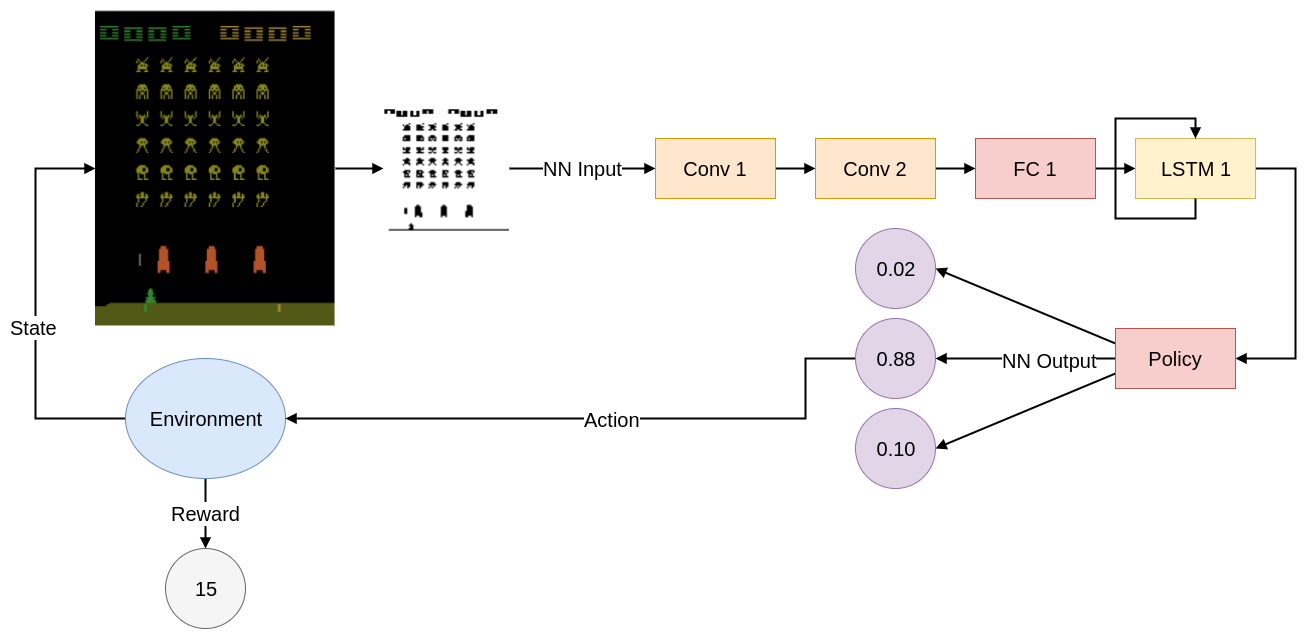

In [13]:
Image('Reinforcement_Learning-101-demo/imgs/Inference_overview.png',width=1000)

In [0]:
class AC_Network():
    def __init__(self, state_size, num_actions, scope):
        with tf.variable_scope(scope):
            
            # Inputs
            self.inputs = tf.placeholder(shape=[None, state_size], dtype=tf.float32)
            self.inputs_reshaped = tf.reshape(self.inputs, shape=[-1, 84, 84, 1])
            
            
            # Conv net - image analysis
            self.conv1 = tf.layers.conv2d(inputs=self.inputs_reshaped,
                                          filters=16,
                                          kernel_size=[8, 8],
                                          strides=[4, 4],
                                          activation=tf.nn.elu,
                                          padding='SAME')
            self.conv2 = tf.layers.conv2d(inputs=self.conv1,
                                          filters=32,
                                          kernel_size=[4, 4],
                                          strides=[2, 2],
                                          activation=tf.nn.elu,
                                          padding='SAME')
            
            # Fully connected - image analysis
            self.fc1 = tf.layers.dense(inputs=tf.layers.flatten(self.conv2),
                                       units=256,
                                       activation=tf.nn.elu)
            

            # LSTM - include information about the history in the predictions
            lstm_state_size = 256
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_state_size, state_is_tuple=True)
            
            # create initial state
            self.initial_state = (np.zeros([1,lstm_state_size]),np.zeros([1,lstm_state_size]))
            
            # create state placeholders
            c_input_state = tf.placeholder(shape=[1,lstm_state_size], dtype=tf.float32)
            h_input_state = tf.placeholder(shape=[1,lstm_state_size], dtype=tf.float32)
            self.input_state = tf.nn.rnn_cell.LSTMStateTuple(c_input_state,h_input_state)
            
            # reformat input data [batch_size, time_steps, features]
            # our batch size is always 1
            rnn_in = tf.expand_dims(self.fc1, [0])
            
            # define lstm
            lstm_outputs, self.lstm_state = tf.nn.dynamic_rnn(cell=lstm_cell,
                                                              inputs=rnn_in,
                                                              initial_state=self.input_state,
                                                             )
            
            # reshape the outputs so that shape = [time_steps, lstm_state_size]
            # our batch size is always 1, so we can remove it
            rnn_out = tf.reshape(lstm_outputs, [-1, lstm_state_size])
            
                        
            # Policy - probabilities of each action
            self.policy = tf.layers.dense(inputs=rnn_out,
                                          units=num_actions,
                                          activation=tf.nn.softmax)

### Initializing the model

In [0]:
# reset session, you can run from here instead of restarting notebook
tf.reset_default_graph()

We create the model with the AC_Network class.

We set the scope to 'global' because we want to load the global network from the checkpoint.

In [0]:
# define the NN
network = AC_Network(state_size, num_actions, 'global')

We can now get the model from the checkpoint after creating our session.

In [17]:
saver = tf.train.Saver()

# create session, initialize variables and load variables from checkpoint
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver.restore(sess, model_checkpoint)

INFO:tensorflow:Restoring parameters from /content/logdir/run_01-lr_0.0001-nw_24-tmax_50/final_model.ckpt


### Testing

#### Recording a game

Lets watch it play a game.

You can use this function to get all the frames from a game also:

`helper.display_test(sess,network)`

In [19]:
# Run 1 game until all lives lost

# create the environment
env = gym.make('SpaceInvaders-v4')
# reset the environment and get the first frame
initial_state = env.reset()
# process the first frame so it's 84x84 and binary
processed_state = helper.preprocess_frame(initial_state).reshape(1,-1)
# set the input state
input_state = processed_state
# create an unprocessed state to plot
unprocessed_state = initial_state

# get the initial lstm state
current_lstm_states = network.initial_state

# set where the game is done or not
done = False

# initialize rewards and steps values
total_reward = 0
total_steps = 0

# initialize array to hold all frames
frames = np.expand_dims(unprocessed_state,axis=0)

# while the environment says the game is not done
while done == False:
  
    if total_steps % 20 == 0:
        sys.stdout.write('\r'+str(total_steps)+' frames')
        sys.stdout.flush()
    
    # get the actions probabilities and updates lstm state
    # input the state and the current lstm state
    actions, current_lstm_states = sess.run([network.policy,network.lstm_state],
                                            feed_dict={network.inputs:input_state,
                                                       network.input_state[0]:current_lstm_states[0],
                                                       network.input_state[1]:current_lstm_states[1]})
    
    # take a step in the environment using the highest probability action
    unprocessed_state1, reward, done, info = env.step(np.argmax(actions))
    # process new state
    processed_state1 = helper.preprocess_frame(unprocessed_state1).reshape(1,-1)
    # set the input state for the next step as the maximum pixel value of the current and updated state
    input_state = np.maximum(processed_state,processed_state1)
    
    # save new frame
    frames = np.append(frames,np.expand_dims(np.maximum(unprocessed_state,unprocessed_state1),axis=0),axis=0)

    # set the processed state for the next step as the new processed state for the current state
    processed_state = processed_state1
    # set the unprocessed state for the next step as the new unprocessed state for the current state
    unprocessed_state = unprocessed_state1
    
    # update the rewards and steps
    total_reward += reward
    total_steps += 1
    
print('\nsteps:',total_steps,'reward:',total_reward)

1200 frames
steps: 1212 reward: 1050.0


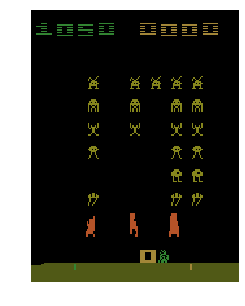

In [20]:
# create video and play as output
anim = helper.create_gameplay_video(frames,figsize=(5,5),save=False)
HTML(anim.to_jshtml())

#### Playing a game live

We can also see it play a game live.

1. Run the cell below
2. click on the link
3. enter the password
4. run the next cell and a terminal should open in a window. if it doesn't, run the cell again.
5. in the terminal enter `run`

In [21]:
import os
!bash /content/Reinforcement_Learning-101-demo/scripts/kill-novnc.sh >/dev/null
!sleep 2
os.environ['PATH'] += "${PATH}:/opt/VirtualGL/bin:/opt/TurboVNC/bin"
!timeout 5 /opt/websockify/run 5901 --web=/opt/noVNC --wrap-mode=ignore -- /opt/TurboVNC/bin/vncserver :1 -securitytypes otp -otp -noxstartup 2>/dev/null
get_ipython().system_raw('python /opt/websockify/run 5901 --web=/opt/noVNC --wrap-mode=ignore -- /opt/TurboVNC/bin/vncserver :1 -securitytypes otp -otp -noxstartup > /content/.vnc/stdout 2>&1 &')
get_ipython().system_raw('/content/ngrok http -config=/content/config.yml 5901 &')
!curl -s http://localhost:4045/api/tunnels | python3 -c "import sys, json; print('XWindow Link:', json.load(sys.stdin)['tunnels'][0]['public_url'])"
get_ipython().system_raw('DISPLAY=:1 openbox &')
!grep "one-time password:" /content/.vnc/stdout

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
XWindow Link: http://8750ad25.ngrok.io
Full control one-time password: 18475425


In [0]:
get_ipython().system_raw('/usr/bin/Xvfb :99 -screen 0 768x1024x24 &')
get_ipython().system_raw('/usr/bin/x11vnc -rfbport 5902 -forever -display :99 &')
get_ipython().system_raw('DISPLAY=:1 /usr/bin/vncviewer localhost:5902 &')
get_ipython().system_raw('DISPLAY=:99 xterm &')

#### Looking at the average total rewards

Now lets test it over a few games and see the average steps and rewards.

In [24]:
# play a number of games with our model
# show average steps and reward
history = np.empty([0,2])

for i in range(10):
    total_steps,total_reward = helper.test(sess,network)
    history = np.append(history, np.array([[total_reward,total_steps]]),axis=0)
    print('game:',i,'steps:',total_steps,'reward:',total_reward)
average_reward, average_steps = np.mean(history,axis=0)
print('average steps:', average_steps, 'average reward:', average_reward)

game: 0 steps: 1304 reward: 1000.0
game: 1 steps: 770 reward: 510.0
game: 2 steps: 1036 reward: 795.0
game: 3 steps: 1014 reward: 805.0
game: 4 steps: 1180 reward: 800.0
game: 5 steps: 1425 reward: 1055.0
game: 6 steps: 921 reward: 825.0
game: 7 steps: 1696 reward: 1085.0
game: 8 steps: 1917 reward: 1255.0
game: 9 steps: 670 reward: 525.0
average steps: 1193.3 average reward: 865.5


To let you understand how a completely random model would do, the below will show the average steps and reward.

In [25]:
# play a number of games with random actions
# show average steps and reward
history = np.empty([0,2])

for i in range(10):
    
    env = gym.make('SpaceInvaders-v4')
    s = env.reset()
    d = False
    total_reward = 0
    total_steps = 0
    while d == False:

        s1, r, d, info = env.step(env.action_space.sample())
        total_reward += r
        total_steps += 1
        
    history = np.append(history, np.array([[total_reward,total_steps]]),axis=0) 
    print('game:',i,'steps:',total_steps,'reward:',total_reward)
average_reward, average_steps = np.mean(history,axis=0)
print('average steps:', average_steps, 'average reward:', average_reward)

game: 0 steps: 801 reward: 365.0
game: 1 steps: 819 reward: 155.0
game: 2 steps: 811 reward: 180.0
game: 3 steps: 391 reward: 80.0
game: 4 steps: 1353 reward: 510.0
game: 5 steps: 804 reward: 185.0
game: 6 steps: 645 reward: 105.0
game: 7 steps: 379 reward: 105.0
game: 8 steps: 681 reward: 110.0
game: 9 steps: 437 reward: 10.0
average steps: 712.1 average reward: 180.5
